# Step 1: Data Loading and Initial Inspection

In [1]:
import pandas as pd

df = pd.read_csv('../data/Copy of BrentOilPrices.csv')

print(df.head())

print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

print(df.describe())

        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None

Missing Values:
 Date     0
Price    0
dtype: int64
             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


# Step 2: Data Cleaning and Preprocessing

In [2]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')

missing_dates = df['Date'].isna().sum()
if missing_dates > 0:
    print(f"There are {missing_dates} dates that couldn't be converted.")
    print("Inspecting rows with conversion errors:")
    print(df[df['Date'].isna()])

df.set_index('Date', inplace=True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None


In [3]:
df.to_csv('../data/cleaned_data.csv')

In [4]:
df_cleaned = pd.read_csv('../data/cleaned_data.csv')

# Step 3: Exploratory Data Analysis (EDA)

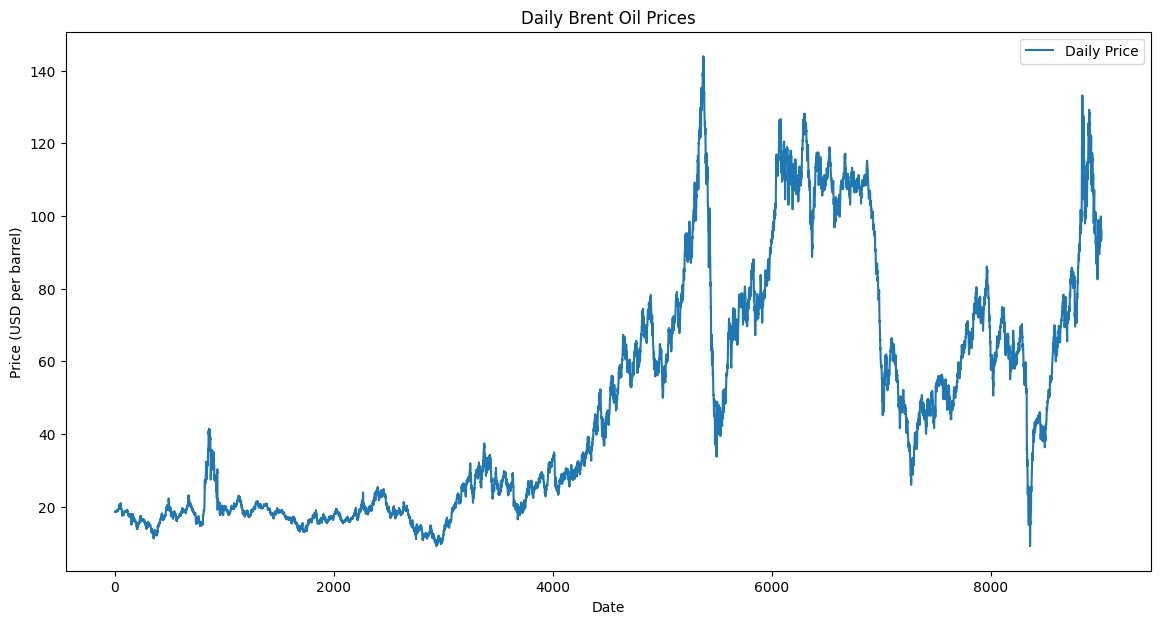

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['Price'], label='Daily Price')
plt.title('Daily Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()